In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

In [2]:
df = pd.read_csv("cell-count.csv")

df.head()

,project,subject,condition,age,sex,treatment,response,sample,sample_type,time_from_treatment_start,b_cell,cd8_t_cell,cd4_t_cell,nk_cell,monocyte
0,prj1,sbj000,melanoma,57,M,miraclib,no,sample00000,PBMC,0,10908,24440,20491,13864,23511
1,prj1,sbj000,melanoma,57,M,miraclib,no,sample00001,PBMC,7,6777,19407,33459,18170,23011
2,prj1,sbj000,melanoma,57,M,miraclib,no,sample00002,PBMC,14,9794,22940,24274,17482,18332
3,prj1,sbj001,carcinoma,68,M,miraclib,yes,sample00003,PBMC,0,10081,20271,36157,14041,12610
4,prj1,sbj001,carcinoma,68,M,miraclib,yes,sample00004,PBMC,7,4372,33778,38293,16527,14933


In [3]:
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nInfo:")
df.info()

Shape: (10500, 15)

Columns: ['project', 'subject', 'condition', 'age', 'sex', 'treatment', 'response', 'sample', 'sample_type', 'time_from_treatment_start', 'b_cell', 'cd8_t_cell', 'cd4_t_cell', 'nk_cell', 'monocyte']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   project                    10500 non-null  object
 1   subject                    10500 non-null  object
 2   condition                  10500 non-null  object
 3   age                        10500 non-null  int64 
 4   sex                        10500 non-null  object
 5   treatment                  10500 non-null  object
 6   response                   9078 non-null   object
 7   sample                     10500 non-null  object
 8   sample_type                10500 non-null  object
 9   time_from_treatment_start  10500 non-null  int64 
 10  

In [4]:
# Ensure all cell count columns are numeric
cell_cols = ["b_cell", "cd8_t_cell", "cd4_t_cell", "nk_cell", "monocyte"]
df[cell_cols] = df[cell_cols].apply(pd.to_numeric, errors="coerce")

# Optional: check for missing values
df[cell_cols].isna().sum()

b_cell        0
cd8_t_cell    0
cd4_t_cell    0
nk_cell       0
monocyte      0
dtype: int64

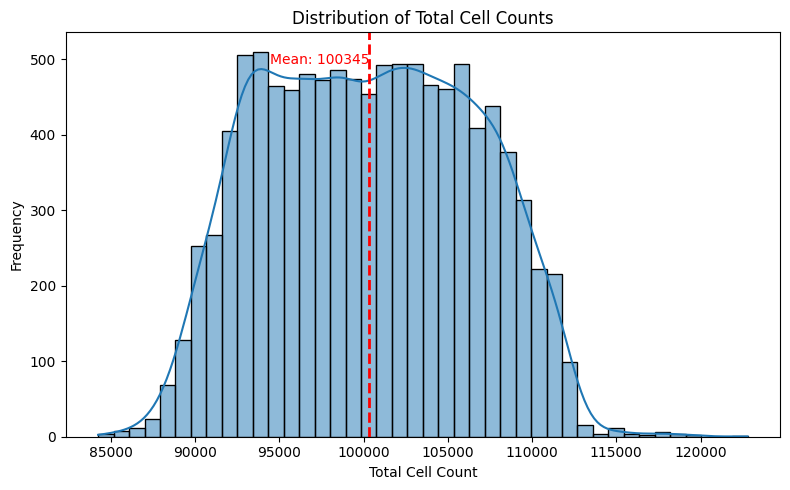

In [5]:
# Compute total cell count
df["total_count"] = df[cell_cols].sum(axis=1)

# Calculate mean
mean_value = df["total_count"].mean()

# Plot histogram + KDE + mean line
plt.figure(figsize=(8,5))
sns.histplot(df["total_count"], kde=True)

plt.axvline(mean_value, color='red', linestyle='--', linewidth=2)
plt.text(mean_value, plt.ylim()[1]*0.95, f"Mean: {mean_value:.0f}", 
         ha='right', va='top', color='red')

plt.xlabel("Total Cell Count")
plt.ylabel("Frequency")
plt.title("Distribution of Total Cell Counts")
plt.tight_layout()
plt.show()

In [6]:
# Compute relative frequency (%) for each cell type and add as new columns
for col in cell_cols:
    df[f"{col}_pct"] = (df[col] / df["total_count"]) * 100

# Preview the extended DataFrame
df.head()

,project,subject,condition,age,sex,treatment,response,sample,sample_type,time_from_treatment_start,b_cell,cd8_t_cell,cd4_t_cell,nk_cell,monocyte,total_count,b_cell_pct,cd8_t_cell_pct,cd4_t_cell_pct,nk_cell_pct,monocyte_pct
0,prj1,sbj000,melanoma,57,M,miraclib,no,sample00000,PBMC,0,10908,24440,20491,13864,23511,93214,11.702105,26.219237,21.982749,14.873302,25.222606
1,prj1,sbj000,melanoma,57,M,miraclib,no,sample00001,PBMC,7,6777,19407,33459,18170,23011,100824,6.721614,19.248393,33.185551,18.021503,22.822939
2,prj1,sbj000,melanoma,57,M,miraclib,no,sample00002,PBMC,14,9794,22940,24274,17482,18332,92822,10.551378,24.713969,26.151128,18.833897,19.749628
3,prj1,sbj001,carcinoma,68,M,miraclib,yes,sample00003,PBMC,0,10081,20271,36157,14041,12610,93160,10.821168,21.759339,38.811722,15.071919,13.535852
4,prj1,sbj001,carcinoma,68,M,miraclib,yes,sample00004,PBMC,7,4372,33778,38293,16527,14933,107903,4.051787,31.304042,35.488355,15.316534,13.839282


In [7]:
# List of cell percentage columns
cell_pct_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct"]

# Step 1: Pivot the DataFrame so each subject has one row per timepoint, columns appended with time
df_wide = df.pivot_table(
    index="subject",
    columns="time_from_treatment_start",
    values=cell_pct_cols
)

# Step 2: Flatten the multiindex columns
df_wide.columns = [f"{col}_{t}" for col, t in df_wide.columns]

# Step 3: Merge back condition and response info per subject
subject_info = df.groupby("subject")[["condition", "response"]].first()
df_wide = df_wide.merge(subject_info, left_index=True, right_index=True)

# Step 4: Preview
df_wide.head()

,b_cell_pct_0,b_cell_pct_7,b_cell_pct_14,cd4_t_cell_pct_0,cd4_t_cell_pct_7,cd4_t_cell_pct_14,cd8_t_cell_pct_0,cd8_t_cell_pct_7,cd8_t_cell_pct_14,monocyte_pct_0,monocyte_pct_7,monocyte_pct_14,nk_cell_pct_0,nk_cell_pct_7,nk_cell_pct_14,condition,response
subject,,,,,,,,,,,,,,,,,
sbj000,11.702105,6.721614,10.551378,21.982749,33.185551,26.151128,26.219237,19.248393,24.713969,25.222606,22.822939,19.749628,14.873302,18.021503,18.833897,melanoma,no
sbj001,10.821168,4.051787,14.646115,38.811722,35.488355,29.238129,21.759339,31.304042,30.315398,13.535852,13.839282,14.976414,15.071919,15.316534,10.823945,carcinoma,yes
sbj002,5.910357,10.569577,9.771673,28.383146,34.412338,23.581951,31.366889,13.720231,29.013979,21.654940,18.319719,18.126681,12.684667,22.978135,19.505716,melanoma,no
sbj003,7.983636,12.277635,11.825419,22.017094,25.919451,32.723933,34.787781,19.843403,22.029728,16.359671,29.676297,18.367756,18.851817,12.283214,15.053165,melanoma,no
sbj004,12.892981,9.755407,6.579910,36.795371,28.950205,29.302291,19.821316,18.261362,27.825497,17.158397,20.160200,26.331482,13.331934,22.872826,9.960820,carcinoma,yes


In [8]:
# List of cell percentage columns
cell_pct_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct"]

# Step 1: Pivot the DataFrame to have columns per timepoint
df_pivot = df.pivot_table(
    index="subject",
    columns="time_from_treatment_start",
    values=cell_pct_cols
)

# Step 2: Compute delta from week 0 to week 14 for each cell type
df_delta = pd.DataFrame(index=df_pivot.index)

for col in cell_pct_cols:
    df_delta[f"{col}_delta"] = df_pivot[col][14] - df_pivot[col][0]

# Step 3: Merge back condition and response info
subject_info = df.groupby("subject")[["condition", "response"]].first()
df_wide = df_delta.merge(subject_info, left_index=True, right_index=True)

# Step 4: Preview
df_wide.head()

,b_cell_pct_delta,cd8_t_cell_pct_delta,cd4_t_cell_pct_delta,nk_cell_pct_delta,monocyte_pct_delta,condition,response
subject,,,,,,,
sbj000,-1.150727,-1.505269,4.168379,3.960595,-5.472978,melanoma,no
sbj001,3.824947,8.556059,-9.573593,-4.247974,1.440562,carcinoma,yes
sbj002,3.861316,-2.352911,-4.801195,6.821049,-3.528259,melanoma,no
sbj003,3.841783,-12.758054,10.706838,-3.798653,2.008085,melanoma,no
sbj004,-6.313071,8.004181,-7.493081,-3.371114,9.173085,carcinoma,yes


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/python/3.12.1/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


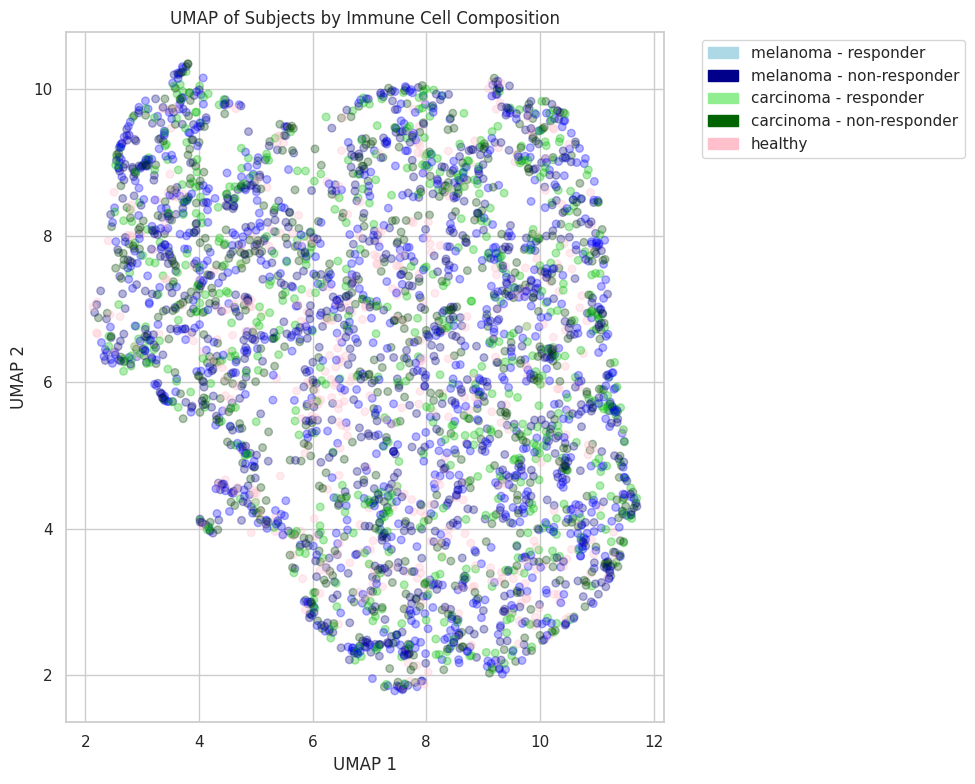

In [10]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Step 1: Prepare wide-format columns for UMAP
cell_pct_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct"]
umap_cols = [col for col in df_wide.columns if any(base.split('_')[0] in col for base in cell_pct_cols)]

# Step 2: Apply UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(df_wide[umap_cols])
df_wide["UMAP1"] = embedding[:,0]
df_wide["UMAP2"] = embedding[:,1]

# Step 3: Define colors
condition_colors = {
    "melanoma": "blue",
    "carcinoma": "green",
    "healthy": "pink"
}

def adjust_color(row):
    if row["condition"] == "healthy":
        return "pink"
    base = mcolors.to_rgb(condition_colors[row["condition"]])
    factor = 1.5 if row["response"] == "yes" else 0.5
    return tuple(min(1, c*factor) for c in base)

df_wide["color"] = df_wide.apply(adjust_color, axis=1)

# Step 4: Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10,8))
plt.scatter(
    df_wide["UMAP1"], df_wide["UMAP2"],
    c=df_wide["color"],
    alpha=0.3,
    s=30
)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP of Subjects by Immune Cell Composition")

# Step 5: Add legend
patches = [
    mpatches.Patch(color='lightblue', label='melanoma - responder'),
    mpatches.Patch(color='darkblue', label='melanoma - non-responder'),
    mpatches.Patch(color='lightgreen', label='carcinoma - responder'),
    mpatches.Patch(color='darkgreen', label='carcinoma - non-responder'),
    mpatches.Patch(color='pink', label='healthy')
]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [11]:
df.head()

,project,subject,condition,age,sex,treatment,response,sample,sample_type,time_from_treatment_start,b_cell,cd8_t_cell,cd4_t_cell,nk_cell,monocyte,total_count,b_cell_pct,cd8_t_cell_pct,cd4_t_cell_pct,nk_cell_pct,monocyte_pct
0,prj1,sbj000,melanoma,57,M,miraclib,no,sample00000,PBMC,0,10908,24440,20491,13864,23511,93214,11.702105,26.219237,21.982749,14.873302,25.222606
1,prj1,sbj000,melanoma,57,M,miraclib,no,sample00001,PBMC,7,6777,19407,33459,18170,23011,100824,6.721614,19.248393,33.185551,18.021503,22.822939
2,prj1,sbj000,melanoma,57,M,miraclib,no,sample00002,PBMC,14,9794,22940,24274,17482,18332,92822,10.551378,24.713969,26.151128,18.833897,19.749628
3,prj1,sbj001,carcinoma,68,M,miraclib,yes,sample00003,PBMC,0,10081,20271,36157,14041,12610,93160,10.821168,21.759339,38.811722,15.071919,13.535852
4,prj1,sbj001,carcinoma,68,M,miraclib,yes,sample00004,PBMC,7,4372,33778,38293,16527,14933,107903,4.051787,31.304042,35.488355,15.316534,13.839282


In [12]:
# List of cell percentage columns
cell_pct_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct"]

# Filter dataset
df_miraclib = df[
    (df["condition"] == "melanoma") &
    (df["treatment"] == "miraclib") &
    (df["sample_type"] == "PBMC")
].copy()

# Optional: check number of responders vs non-responders
print(df_miraclib["response"].value_counts())

# Preview the filtered data
df_miraclib[["subject", "sample", "response"] + cell_pct_cols].head()

response
yes    993
no     975
Name: count, dtype: int64


,subject,sample,response,b_cell_pct,cd8_t_cell_pct,cd4_t_cell_pct,nk_cell_pct,monocyte_pct
0,sbj000,sample00000,no,11.702105,26.219237,21.982749,14.873302,25.222606
1,sbj000,sample00001,no,6.721614,19.248393,33.185551,18.021503,22.822939
2,sbj000,sample00002,no,10.551378,24.713969,26.151128,18.833897,19.749628
6,sbj002,sample00006,no,5.910357,31.366889,28.383146,12.684667,21.654940
7,sbj002,sample00007,no,10.569577,13.720231,34.412338,22.978135,18.319719


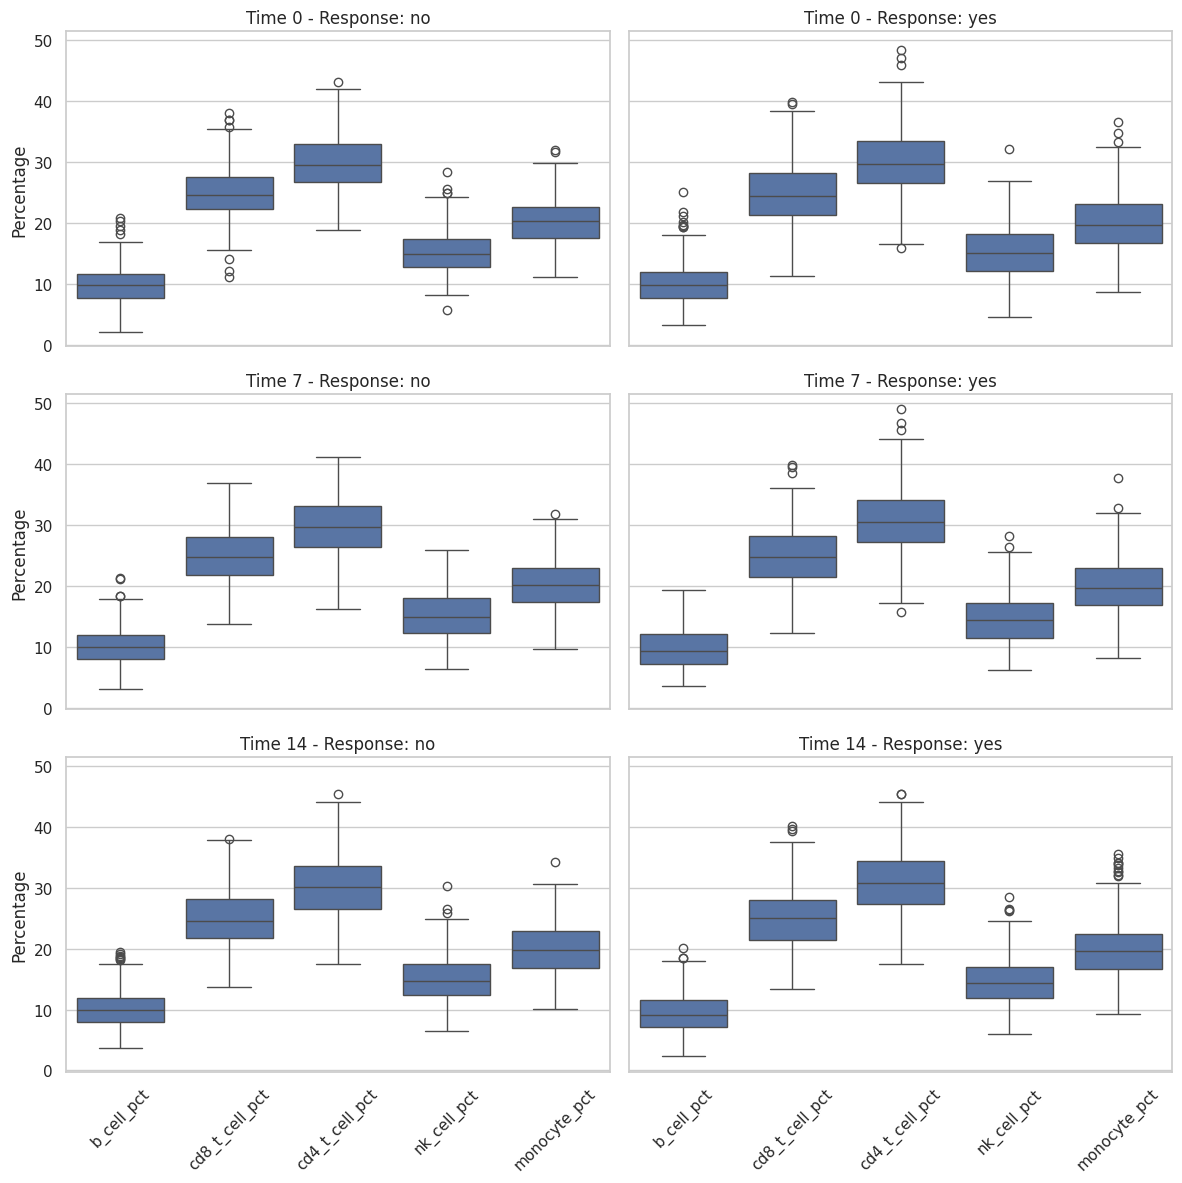

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of cell percentage columns
cell_pct_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct"]

# Timepoints to plot
timepoints = [0, 7, 14]

# Response categories
responses = ["no", "yes"]

# Initialize figure
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12), sharey=True)
sns.set(style="whitegrid")

# Loop over timepoints and responses
for i, t in enumerate(timepoints):
    for j, resp in enumerate(responses):
        ax = axes[i, j]
        # Filter data
        df_sub = df_miraclib[(df_miraclib["time_from_treatment_start"] == t) & 
                             (df_miraclib["response"] == resp)]
        
        # Melt to long format for seaborn boxplot
        df_long = df_sub.melt(
            id_vars=["sample"],
            value_vars=cell_pct_cols,
            var_name="cell_type",
            value_name="percentage"
        )
        
        # Boxplot
        sns.boxplot(x="cell_type", y="percentage", data=df_long, ax=ax)
        ax.set_title(f"Time {t} - Response: {resp}")
        ax.set_xlabel("")  # Remove x-label by default
        ax.set_ylabel("Percentage" if j == 0 else "")  # Only left column has y-label
        ax.tick_params(axis='x', rotation=45)
        
        # Only show x-axis labels for bottom row
        if i < len(timepoints) - 1:
            ax.set_xticklabels([])

plt.tight_layout()
plt.show()

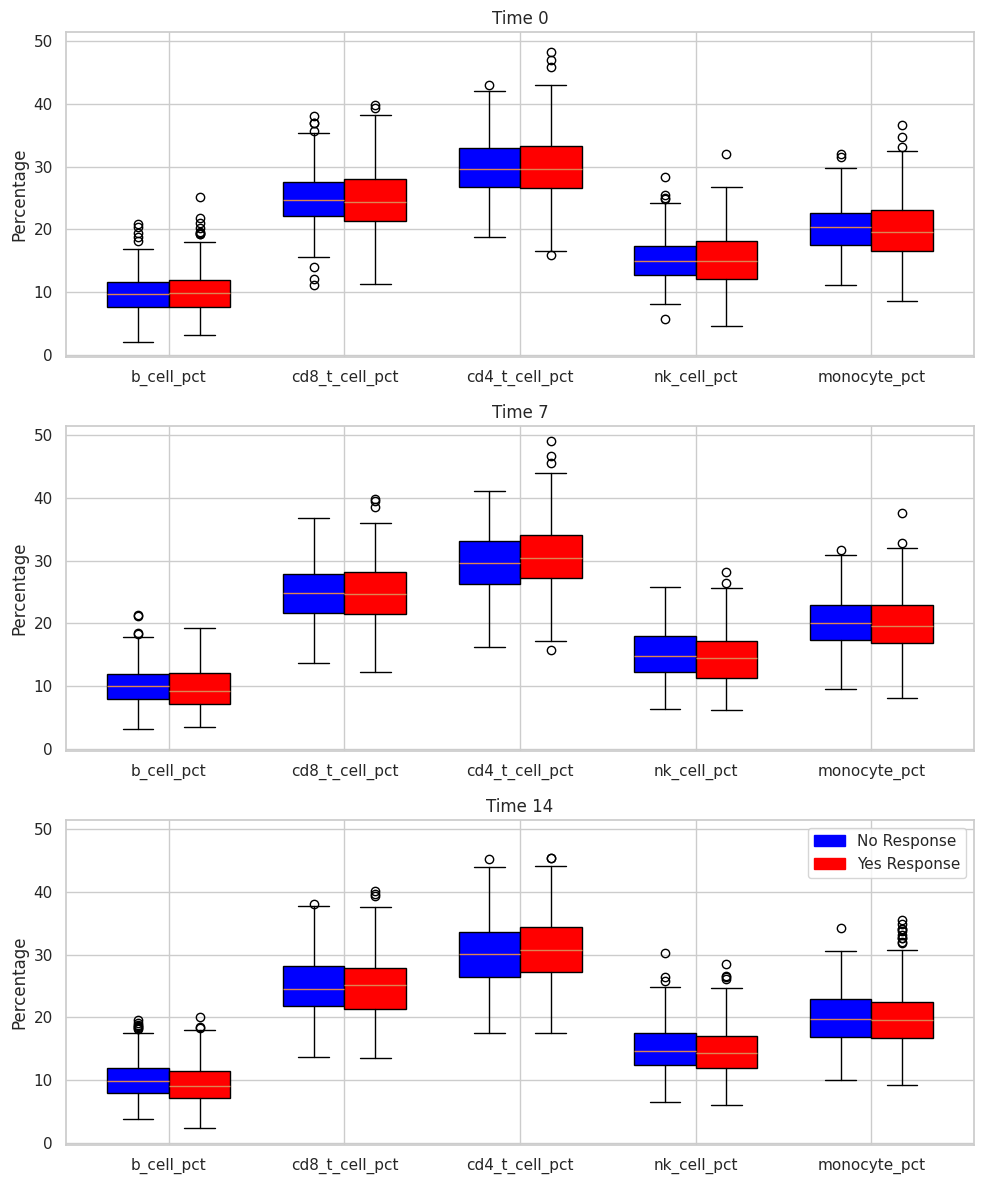

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# List of cell percentage columns
cell_pct_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct"]

# Response colors
response_colors = {"no": "blue", "yes": "red"}

# Timepoints to plot
timepoints = [0, 7, 14]

# Initialize figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharey=True)

# Width for each boxplot
width = 0.35  # half-width for each response
spacing = 1.0  # distance between cell types

for i, t in enumerate(timepoints):
    ax = axes[i]
    positions = []
    labels = []
    data_to_plot = []

    # Loop through cell types
    for j, cell in enumerate(cell_pct_cols):
        # No response
        no_data = df_miraclib[(df_miraclib["time_from_treatment_start"]==t) & 
                              (df_miraclib["response"]=="no")][cell]
        yes_data = df_miraclib[(df_miraclib["time_from_treatment_start"]==t) & 
                               (df_miraclib["response"]=="yes")][cell]
        
        # Compute positions
        base_pos = j * spacing
        positions.extend([base_pos - width/2, base_pos + width/2])
        data_to_plot.extend([no_data, yes_data])
        labels.extend([cell if j==0 else "", cell if j==0 else ""])  # x-tick labels will only be shown once

    # Create boxplots
    bplots = ax.boxplot(data_to_plot, positions=positions, widths=width, patch_artist=True, manage_ticks=False)

    # Color the boxes
    for k, box in enumerate(bplots['boxes']):
        if k % 2 == 0:
            box.set_facecolor("blue")   # no response
        else:
            box.set_facecolor("red")    # yes response

    # Set title
    ax.set_title(f"Time {t}")
    ax.set_xticks([j * spacing for j in range(len(cell_pct_cols))])
    ax.set_xticklabels(cell_pct_cols)
    ax.set_ylabel("Percentage")

    if i == 0:
    # Add legend
        legend_handles = [mpatches.Patch(color="blue", label="No Response"),
                        mpatches.Patch(color="red", label="Yes Response")]
        plt.legend(handles=legend_handles, loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
# Filter for baseline PBMC samples of melanoma patients treated with miraclib
df_baseline = df_miraclib[df_miraclib["time_from_treatment_start"] == 0]

# Check responder counts
df_baseline["response"].value_counts()

from scipy.stats import mannwhitneyu

# List of cell percentage columns
cell_pct_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct"]

# Perform test for each cell type
results = []

for col in cell_pct_cols:
    group_yes = df_baseline[df_baseline["response"] == "yes"][col]
    group_no  = df_baseline[df_baseline["response"] == "no"][col]
    
    stat, p_value = mannwhitneyu(group_yes, group_no, alternative='two-sided')
    results.append({"cell_type": col, "statistic": stat, "p_value": p_value})

# Convert to DataFrame for easy viewing
df_stats = pd.DataFrame(results)

# Define significance threshold
alpha = 0.05

# Add a column indicating significance
df_stats["significant"] = df_stats["p_value"] < alpha

# Optional: add a human-readable conclusion
df_stats["conclusion"] = df_stats["significant"].apply(
    lambda x: "May impact response" if x else "No evidence of impact"
)

# Display results
df_stats[["cell_type", "p_value", "significant", "conclusion"]]

,cell_type,p_value,significant,conclusion
0,b_cell_pct,0.548541,False,No evidence of impact
1,cd8_t_cell_pct,0.513956,False,No evidence of impact
2,cd4_t_cell_pct,0.796450,False,No evidence of impact
3,nk_cell_pct,0.885328,False,No evidence of impact
4,monocyte_pct,0.211389,False,No evidence of impact


In [18]:
# Step 1: Filter baseline melanoma PBMC samples treated with miraclib
df_baseline = df[
    (df["condition"] == "melanoma") &
    (df["treatment"] == "miraclib") &
    (df["sample_type"] == "PBMC") &
    (df["time_from_treatment_start"] == 0)
].copy()

# Step 2a: How many samples from each project
samples_per_project = df_baseline.groupby("project")["sample"].nunique()
print("Number of baseline samples per project:")
print(samples_per_project)

# Step 2b: How many subjects were responders/non-responders
subjects_per_response = df_baseline.groupby("response")["subject"].nunique()
print("\nNumber of subjects by response:")
print(subjects_per_response)

# Step 2c: How many subjects were males/females
subjects_per_sex = df_baseline.groupby("sex")["subject"].nunique()
print("\nNumber of subjects by sex:")
print(subjects_per_sex)

Number of baseline samples per project:
project
prj1    384
prj3    272
Name: sample, dtype: int64

Number of subjects by response:
response
no     325
yes    331
Name: subject, dtype: int64

Number of subjects by sex:
sex
F    312
M    344
Name: subject, dtype: int64


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Filter baseline melanoma PBMC samples
df_baseline = df[
    (df["condition"] == "melanoma") &
    (df["treatment"] == "miraclib") &
    (df["sample_type"] == "PBMC") &
    (df["time_from_treatment_start"] == 0)
].copy()

# Features and target
feature_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct", "sex"]
X = df_baseline[feature_cols].copy()
y = df_baseline["response"]

# Encode categorical variable 'sex'
X["sex"] = LabelEncoder().fit_transform(X["sex"])  # M=1, F=0

# Encode target
y = LabelEncoder().fit_transform(y)  # no=0, yes=1

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate performance
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["no", "yes"]))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# Optional: feature importances
importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("\nFeature Importances:")
print(importances)

Classification Report:

              precision    recall  f1-score   support

          no       0.54      0.64      0.59        98
         yes       0.57      0.46      0.51        99

    accuracy                           0.55       197
   macro avg       0.56      0.55      0.55       197
weighted avg       0.56      0.55      0.55       197

Confusion Matrix:

[[63 35]
 [53 46]]

Feature Importances:
cd8_t_cell_pct    0.222216
monocyte_pct      0.199761
nk_cell_pct       0.189596
b_cell_pct        0.187292
cd4_t_cell_pct    0.173946
sex               0.027190
dtype: float64


In [20]:
# List of cell percentage columns
cell_pct_cols = ["b_cell_pct", "cd8_t_cell_pct", "cd4_t_cell_pct", "nk_cell_pct", "monocyte_pct"]

# Filter melanoma PBMC samples treated with miraclib
df_mela = df[
    (df["condition"] == "melanoma") &
    (df["treatment"] == "miraclib") &
    (df["sample_type"] == "PBMC")
].copy()

# Pivot to have one row per subject, columns per timepoint
df_pivot = df_mela.pivot_table(
    index="subject",
    columns="time_from_treatment_start",
    values=cell_pct_cols
)

# Create features DataFrame
df_features = pd.DataFrame(index=df_pivot.index)

# Add baseline percentages (time 0)
for col in cell_pct_cols:
    df_features[f"{col}_baseline"] = df_pivot[col][0]

# Compute delta features
for col in cell_pct_cols:
    df_features[f"{col}_delta_0_7"]  = df_pivot[col][7]  - df_pivot[col][0]
    df_features[f"{col}_delta_0_14"] = df_pivot[col][14] - df_pivot[col][0]

# Merge back sex and response
subject_info = df_mela.groupby("subject")[["sex", "response"]].first()
df_features = df_features.merge(subject_info, left_index=True, right_index=True)

# Preview
df_features.head()

,b_cell_pct_baseline,cd8_t_cell_pct_baseline,cd4_t_cell_pct_baseline,nk_cell_pct_baseline,monocyte_pct_baseline,b_cell_pct_delta_0_7,b_cell_pct_delta_0_14,cd8_t_cell_pct_delta_0_7,cd8_t_cell_pct_delta_0_14,cd4_t_cell_pct_delta_0_7,cd4_t_cell_pct_delta_0_14,nk_cell_pct_delta_0_7,nk_cell_pct_delta_0_14,monocyte_pct_delta_0_7,monocyte_pct_delta_0_14,sex,response
subject,,,,,,,,,,,,,,,,,
sbj000,11.702105,26.219237,21.982749,14.873302,25.222606,-4.980491,-1.150727,-6.970844,-1.505269,11.202802,4.168379,3.148201,3.960595,-2.399667,-5.472978,M,no
sbj002,5.910357,31.366889,28.383146,12.684667,21.654940,4.659219,3.861316,-17.646658,-2.352911,6.029193,-4.801195,10.293468,6.821049,-3.335221,-3.528259,M,no
sbj003,7.983636,34.787781,22.017094,18.851817,16.359671,4.293999,3.841783,-14.944379,-12.758054,3.902357,10.706838,-6.568603,-3.798653,13.316627,2.008085,M,no
sbj008,7.554342,27.829627,35.280937,19.687103,9.647991,4.707261,0.731572,-5.421898,-2.994855,-3.540405,0.787221,1.562923,-5.143945,2.692118,6.620007,F,yes
sbj020,10.658334,20.675334,37.492032,14.062047,17.112253,-6.632256,-0.094348,10.464257,0.423254,-3.303410,-14.871710,0.239105,4.308962,-0.767696,10.233842,F,yes


In [21]:
# Features and target
feature_cols = [c for c in df_features.columns if c not in ["sex", "response"]]
X = df_features[feature_cols].copy()

# Encode categorical 'sex'
X["sex"] = LabelEncoder().fit_transform(df_features["sex"])

# Encode target
y = LabelEncoder().fit_transform(df_features["response"])  # no=0, yes=1

# Split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["no", "yes"]))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# Feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nFeature Importances:")
print(importances)

Classification Report:

              precision    recall  f1-score   support

          no       0.52      0.51      0.51        98
         yes       0.52      0.53      0.52        99

    accuracy                           0.52       197
   macro avg       0.52      0.52      0.52       197
weighted avg       0.52      0.52      0.52       197

Confusion Matrix:

[[50 48]
 [47 52]]

Feature Importances:
cd8_t_cell_pct_baseline      0.088240
cd8_t_cell_pct_delta_0_7     0.085401
monocyte_pct_delta_0_14      0.071562
monocyte_pct_baseline        0.068893
b_cell_pct_delta_0_7         0.066680
nk_cell_pct_delta_0_14       0.064749
b_cell_pct_baseline          0.063999
nk_cell_pct_baseline         0.063374
nk_cell_pct_delta_0_7        0.062613
cd8_t_cell_pct_delta_0_14    0.062145
cd4_t_cell_pct_delta_0_7     0.062081
cd4_t_cell_pct_delta_0_14    0.061644
b_cell_pct_delta_0_14        0.060936
cd4_t_cell_pct_baseline      0.055306
monocyte_pct_delta_0_7       0.053624
sex                